Data Loading

In [1]:
import os
import torch
from torch import nn
import torch.optim as optim
import torchvision.transforms as transforms 
from torchvision import models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader


In [ ]:
#To determine Custom Normalization Metrics
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from tqdm.notebook import tqdm
from time import time

N_CHANNELS = 1

dataset = datasets.MNIST("data", download=True,
                 train=True, transform=transforms.ToTensor())
full_loader = torch.utils.data.DataLoader(dataset, shuffle=False, num_workers=os.cpu_count())

before = time()
mean = torch.zeros(1)
std = torch.zeros(1)
print('==> Computing mean and std..')
for inputs, _labels in tqdm(full_loader):
    for i in range(N_CHANNELS):
        mean[i] += inputs[:,i,:,:].mean()
        std[i] += inputs[:,i,:,:].std()
mean.div_(len(dataset))
std.div_(len(dataset))
print(mean, std)

print("time elapsed: ", time()-before)

Failed to download (trying next):
HTTP Error 404: Not Found



 53%|█████▎    | 5.28M/9.91M [00:20<00:06, 751kB/s] 

In [2]:
transform_dataset = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [3]:
import os
import random 
import shutil



def split_dataset(input_dir, output_dir, train_ratio = 0.8):
    
    #Making Directories
    train_dir = os.path.join(output_dir,'train')
    val_dir = os.path.join(output_dir,'val')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir,exist_ok=True)

    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir,class_name)
        if not os.path.isdir(class_path):
            continue
        
        # Loading All images in this list
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path,f))]
        random.shuffle(images)

        #Splitting for training and Validation
        split_index = int(len(images) * train_ratio)
        train_images = images[:split_index]
        val_images = images[split_index:]

        # Final Path Initalization
        class_train_dir = os.path.join(train_dir,class_name)
        class_val_dir = os.path.join(val_dir,class_name)
        os.makedirs(class_train_dir,exist_ok=True)
        os.makedirs(class_val_dir,exist_ok=True)

        # Copying the images from one folder to other
        for img in train_images:
            src = os.path.join(class_path,img)
            dst = os.path.join(class_train_dir,img)
            shutil.copy(src,dst)

        for img in val_images:
            src = os.path.join(class_path,img)
            dst = os.path.join(class_val_dir,img)
            shutil.copy(src,dst)
        
        print(f"Class '{class_name}' : {len(train_images)} Training images,{len(val_images)} Validation images")

image_dataset_dir = r"d:\MLProjects\JaundiceDetection\dataset"
output_dataset_dir = r"d:\MLProjects\JaundiceDetection\Datasets"

split_dataset(image_dataset_dir,output_dataset_dir,train_ratio=0.8)


Class 'jaundice' : 160 Training images,40 Validation images
Class 'normal' : 448 Training images,112 Validation images


In [4]:
print("Current Wording Directory", os.getcwd())

Current Wording Directory d:\MLProjects\JaundiceDetection


In [ ]:
root_path = r"d:\MLProjects\JaundiceDetection\Datasets"
image_datasets = {x : datasets.ImageFolder(root=os.path.join(root_path,x),
                                            transform=transform_dataset[x]) 
                    for x in ['train','val']}
dataloaders = {x : DataLoader(image_datasets[x], batch_size=16 , shuffle=True, num_workers=5, pin_memory=True) for x in ['train','val']}
dataset_sizes = {x : len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

In [5]:
#To Determine the Dimensions of the Imput and Labels
for inputs, labels in dataloaders['train']:
    print(f"Input batch shape: {inputs.shape}")
    print(f"Labels batch shape: {labels.shape}")
    break

Input batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: torch.Size([16])


In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False

for param in model.layer3.parameters():
    param.requires_grad = True

for param in model.layer4.parameters():
    param.requires_grad = True
    
num_ftrs = model.fc.in_features
print(num_ftrs)
model.fc = nn.Linear(num_ftrs,len(class_names))

In [1]:
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [2]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=2e-5,momentum=0.9)

NameError: name 'nn' is not defined

In [10]:
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

In [17]:
import copy

epochs = 500
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

model.to(device)

for epoch in range(epochs):
    print(f'Epoch {epoch}/{epochs}')
    print('-'*5)

    for phase in ["train","val"]:
        if phase == "train":
            model.train()
        else:
            model.eval()
        
        running_loss = 0.0
        running_corrects = 0

        for input , label in dataloaders[phase]:
            inputs = input.to(device)
            labels = label.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs,1)
                loss = criterion(outputs,labels)

                if phase == 'train':
                 loss.backward()
                 optimizer.step()
                
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        if phase == "train":
            train_loss_list.append(epoch_loss)
            train_acc_list.append(epoch_acc)
        
        if phase == "val":
            val_acc_list.append(epoch_acc)
            val_loss_list.append(epoch_loss)
        
        print(f"{phase} Loss : {epoch_loss:4f} Accuracy : {epoch_acc:4f}")

        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
    


print(f"Best val Acc :{best_acc:4f}")
torch.save(model.state_dict(),"./DetectorModel.pth")   
model.load_state_dict(best_model_wts)    

        
           




Epoch 0/500
-----
train Loss : 0.658157 Accuracy : 0.647368
val Loss : 0.662942 Accuracy : 0.623016
Epoch 1/500
-----
train Loss : 0.658737 Accuracy : 0.643421
val Loss : 0.655115 Accuracy : 0.642857
Epoch 2/500
-----
train Loss : 0.657058 Accuracy : 0.653947
val Loss : 0.660480 Accuracy : 0.630952
Epoch 3/500
-----
train Loss : 0.654631 Accuracy : 0.667105
val Loss : 0.665168 Accuracy : 0.617063
Epoch 4/500
-----
train Loss : 0.658096 Accuracy : 0.651316
val Loss : 0.660317 Accuracy : 0.625000
Epoch 5/500
-----
train Loss : 0.661883 Accuracy : 0.639474
val Loss : 0.657072 Accuracy : 0.632937
Epoch 6/500
-----
train Loss : 0.659685 Accuracy : 0.647368
val Loss : 0.660002 Accuracy : 0.628968
Epoch 7/500
-----
train Loss : 0.658952 Accuracy : 0.659211
val Loss : 0.660928 Accuracy : 0.630952
Epoch 8/500
-----
train Loss : 0.659436 Accuracy : 0.647368
val Loss : 0.656875 Accuracy : 0.628968
Epoch 9/500
-----
train Loss : 0.658161 Accuracy : 0.650000
val Loss : 0.662205 Accuracy : 0.630952


<All keys matched successfully>

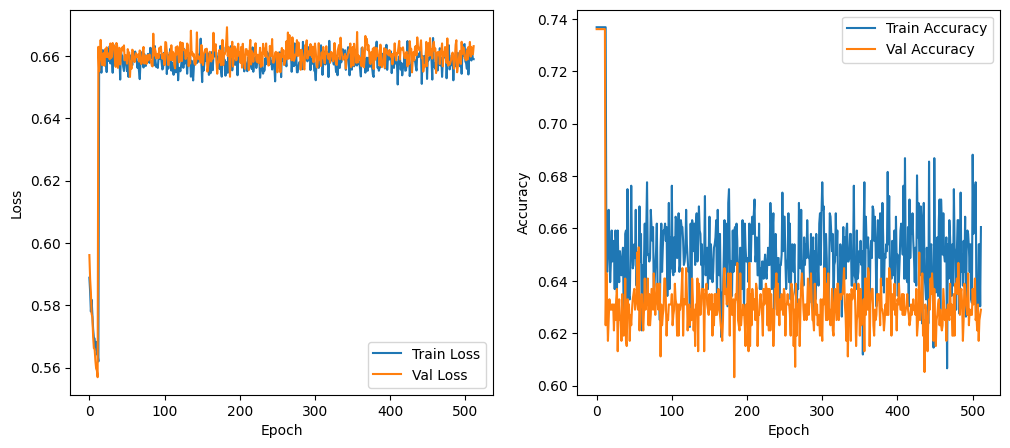

In [23]:
import matplotlib.pyplot as plt

min_length = min(len(train_loss_list), len(val_loss_list), len(train_acc_list), len(val_acc_list))
epochs = range(min_length)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_loss_list[:min_length], label='Train Loss')
plt.plot(epochs, val_loss_list[:min_length], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, [acc.cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in train_acc_list[:min_length]], label='Train Accuracy')
plt.plot(epochs, [acc.cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in val_acc_list[:min_length]], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [28]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Load the model
def load_model(model_path):
    model = models.resnet50(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features,2)
    model.load_state_dict(torch.load(model_path,weights_only=True, map_location=torch.device("cuda:0")))
    model.eval()
    return model

# Preprocess the input image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)
    return image

# Perform inference
def infer(model, image_tensor):
    with torch.no_grad():
        output = model(image_tensor)
    probabilities = torch.nn.functional.softmax(output[0],dim=0)
    return probabilities

imagenet_classes = {0: 'jaundice', 1: 'normal'}
model = load_model("DetectorModel.pth")
image_tensor = preprocess_image("Datasets/val/normal/normal (1001).jpg")
output = infer(model,image_tensor)
top2_prod , top2_catid = torch.topk(output,2)
for i in range(2):
        class_id = top2_catid[i].item()
        class_name = imagenet_classes[class_id] 
        print(f"Class: {class_name}, Probability: {top2_prod[i].item():.4f}")

C:\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Class: jaundice, Probability: 0.5205
Class: normal, Probability: 0.4795


In [25]:
import numpy as np

# Convert lists to numpy arrays (assuming they are stored as lists of floats)
train_loss_array = np.array(train_loss_list)
val_loss_array = np.array(val_loss_list)
train_acc_array = np.array([acc.cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in train_acc_list[:min_length]])
val_acc_array = np.array([acc.cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in val_acc_list[:min_length]])

# Calculate per-epoch differences (slopes)
train_loss_diff = np.diff(train_loss_array)
val_loss_diff = np.diff(val_loss_array)
train_acc_diff = np.diff(train_acc_array)
val_acc_diff = np.diff(val_acc_array)

# Print average change per epoch as proof of learning
print("Average training loss decrease per epoch:", np.mean(train_loss_diff))
print("Average validation loss decrease per epoch:", np.mean(val_loss_diff))
print("Average training accuracy increase per epoch:", np.mean(train_acc_diff))
print("Average validation accuracy increase per epoch:", np.mean(val_acc_diff))

# Calculate correlation between training and validation curves to verify consistency
corr_loss = np.corrcoef(train_loss_array, val_loss_array)[0, 1]
corr_acc = np.corrcoef(train_acc_array, val_acc_array)[0, 1]
print("Correlation between training and validation loss:", corr_loss)
print("Correlation between training and validation accuracy:", corr_acc)


Average training loss decrease per epoch: 0.00013695172169000697
Average validation loss decrease per epoch: 0.00013123654057986756
Average training accuracy increase per epoch: -0.00014934596765887325
Average validation accuracy increase per epoch: -0.00020967291025999433


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 513 and the array at index 1 has size 512

In [11]:
from torchvision import models

def load_model(model_path : str):
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    model.load_state_dict(torch.load(model_path,map_location=device,weights_only=False))
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs,len(class_names))
    model.to(device)
    model.eval()
    return model

In [ ]:
import onnx

dummy_input = torch.randn(3,244,244).to(device)
onnx_path = "DetectorModel.onnx"
model = load_model(model_path="./DetectorModel.pth")

torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={
        "input" : {0 : "batch_size"},
        "output" : {0 : "batch_size"}
    }
)

print(f"Model converted to ONNX: {onnx_path}")